<a href="https://colab.research.google.com/github/danielfang001/moe-profiler/blob/main/elbowanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import sys
import torch
import os
import pickle
from collections import defaultdict
import google.colab
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Running OLMoE and Extracting Router Logits

In [ ]:
# Configuration for datasets
DATASET_CONFIGS = {
    'mmlu': {
        'path': 'cais/mmlu',
        'name': 'all',
        'split': 'test',
        'type': 'mmlu'
    },
    'arc_easy': {
        'path': 'allenai/ai2_arc',
        'name': 'ARC-Easy',
        'split': 'test',
        'type': 'arc'
    },
    'arc_challenge': {
        'path': 'allenai/ai2_arc',
        'name': 'ARC-Challenge',
        'split': 'test',
        'type': 'arc'
    }
}

def load_samples(dataset_key='mmlu', num_samples=5):
    """Generic function to load samples from a configured dataset."""
    if dataset_key not in DATASET_CONFIGS:
        print(f"Dataset key '{dataset_key}' not found in configs.")
        return []

    config = DATASET_CONFIGS[dataset_key]
    print(f"Loading {num_samples} samples from {config['path']} ({config['name']})...")

    try:
        from datasets import load_dataset
    except ImportError:
        print("datasets library not installed. Install with: pip install datasets")
        return []

    try:
        dataset = load_dataset(config['path'], config['name'], split=config['split'])
        indices = torch.randperm(len(dataset))[:num_samples].tolist()
        samples = [dataset[i] for i in indices]

        # Inject 'subject' if missing (useful for ARC, for compatibility with downstream analysis)
        for s in samples:
            if 'subject' not in s:
                s['subject'] = config['name'] # Use dataset subset name as subject

        return samples
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return []

def format_question(sample, dataset_key='mmlu'):
    """Generic function to format questions based on dataset type."""
    config = DATASET_CONFIGS.get(dataset_key, {'type': 'mmlu'}) # Default to mmlu formatting
    ds_type = config['type']

    question = sample['question']

    if ds_type == 'mmlu':
        choices = sample['choices']
        formatted = f"{question}\n"
        for i, choice in enumerate(choices):
            formatted += f"({chr(65 + i)}) {choice}\n"

    elif ds_type == 'arc':
        choices_text = sample['choices']['text']
        choices_label = sample['choices']['label']
        sorted_choices = sorted(zip(choices_label, choices_text))
        formatted = f"{question}\n"
        for label, text in sorted_choices:
            formatted += f"({label}) {text}\n"

    else:
        formatted = question

    return formatted.strip()

def hook_router_logits(model, logits_dict, sample_idx):
    """Attach hooks to all router modules to capture their logits."""
    handles = []

    def create_hook(router_name):
        def hook_fn(module, input, output):
            # output can be logits or (logits, indices) tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            # Convert to CPU and store with sample index
            if logits is not None:
                key = (router_name, sample_idx)
                if key not in logits_dict:
                    logits_dict[key] = []
                logits_dict[key].append(logits.detach().cpu())

        return hook_fn

    # Find all router/gate modules (exclude expert.*.gate_proj which are projection layers)
    for name, module in model.named_modules():
        if ('gate' in name.lower() or 'router' in name.lower()) and 'gate_proj' not in name.lower():
            hook = module.register_forward_hook(create_hook(name))
            handles.append(hook)

    return handles

def run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                       dataset_key="mmlu",
                       num_samples=5,
                       output_file="router_logits.pkl"):
    """Load model, sample dataset, capture router logits."""

    print(f"Loading model {model_name}...")
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
    except ImportError:
        print("transformers library not installed")
        return

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()

    # Load samples
    samples = load_samples(dataset_key, num_samples=num_samples)

    if not samples:
        print("Failed to load samples")
        return

    print(f"Loaded {len(samples)} samples\n")

    # Setup logits collection: key = (router_name, sample_idx), value = list of logit tensors
    logits_dict = defaultdict(list)

    try:
        # Process each sample
        with torch.no_grad():
            for sample_idx, sample in enumerate(samples):
                print(f"Processing sample {sample_idx+1}/{len(samples)}...")

                question_text = format_question(sample, dataset_key)
                print(f"  Question: {question_text[:100]}...")

                # Attach hooks for this sample
                handles = hook_router_logits(model, logits_dict, sample_idx)

                # Tokenize and run forward pass
                inputs = tokenizer(question_text, return_tensors='pt', truncation=True, max_length=512)
                inputs = {k: v.to(model.device) for k, v in inputs.items()}

                # Forward pass (collect logits via hooks)
                _ = model(**inputs, output_hidden_states=False)

                # Remove hooks for this sample
                for handle in handles:
                    handle.remove()

                print(f"  Captured {len([k for k in logits_dict.keys() if k[1] == sample_idx])} routers")

    finally:
        print("\nHooks removed")

    # Reorganize: convert from (router_name, sample_idx) keys to per-sample dicts
    # Structure: {sample_idx: {router_name: logits_tensor}}
    organized_logits = defaultdict(dict)

    for (router_name, sample_idx), logits_list in logits_dict.items():
        # Concatenate all logits from this router on this sample
        try:
            stacked = torch.cat(logits_list, dim=0)
            organized_logits[sample_idx][router_name] = stacked
        except Exception as e:
            # If concatenation fails, keep as list
            organized_logits[sample_idx][router_name] = logits_list

    # Print summary
    print("\nLogits captured per sample:")
    for sample_idx in sorted(organized_logits.keys()):
        print(f"\nSample {sample_idx}:")
        for router_name, logits in organized_logits[sample_idx].items():
            if isinstance(logits, torch.Tensor):
                print(f"  {router_name}: shape {logits.shape}")
            else:
                print(f"  {router_name}: {len(logits)} sequences (variable shapes)")

    # Save to file
    print(f"\nSaving logits to {output_file}...")
    save_data = {
        'model_name': model_name,
        'num_samples': len(samples),
        'samples': samples,  # Keep original samples for reference
        'router_logits': dict(organized_logits),  # Convert defaultdict to dict
        'dataset_key': dataset_key
    }

    with open(output_file, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"Saved! File size: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")

In [ ]:
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="mmlu",
                    num_samples=1000,
                    output_file="mmlu_router_logits.pkl")
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="arc_easy",
                    num_samples=500,
                    output_file="arceasy_router_logits.pkl")
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="arc_challenge",
                    num_samples=500,
                    output_file="arcchallenge_router_logits.pkl")

## Elbow Analysis


In [3]:
with open('/content/drive/MyDrive/mmlu_router_logits.pkl', 'rb') as f:
    mmlu = pickle.load(f)

with open('/content/drive/MyDrive/arceasy_router_logits.pkl', 'rb') as f:
    arceasy = pickle.load(f)

with open('/content/drive/MyDrive/arceasy_router_logits.pkl', 'rb') as f:
    arcchallenge = pickle.load(f)

In [4]:
#define core functions for elbow analysis

x_norm = np.linspace(0, 1, 64)
def calculate_geometric_elbow(y):
    y_norm = (y[:1] - y) / (y[:1] - y[-1:] + 1e-12)
    diff = y_norm - x_norm
    return int(np.argmax(diff))


def elbow_angle(y, elbowidx):
    if elbowidx == 0 or elbowidx == len(y) - 1: return 180.0
    y_np = y if isinstance(y, np.ndarray) else y.cpu().numpy()
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

In [5]:
#Convert all logits to sorted probabilities

def get_all_sorted_logits(dataset_data):
    all_logits = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for sample_idx, routers in dataset_data['router_logits'].items():
        for logits in routers.values():
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)

            # Ensure on correct device
            if device == 'cuda':
                logits = logits.to(device)

            # Softmax & Sort
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)

            # Move to CPU numpy
            all_logits.extend(sorted_probs.cpu().numpy())

    return all_logits

#get data
arceasy_logits = get_all_sorted_logits(arceasy)
arcchallenge_logits = get_all_sorted_logits(arcchallenge)
mmlulogits = get_all_sorted_logits(mmlu)

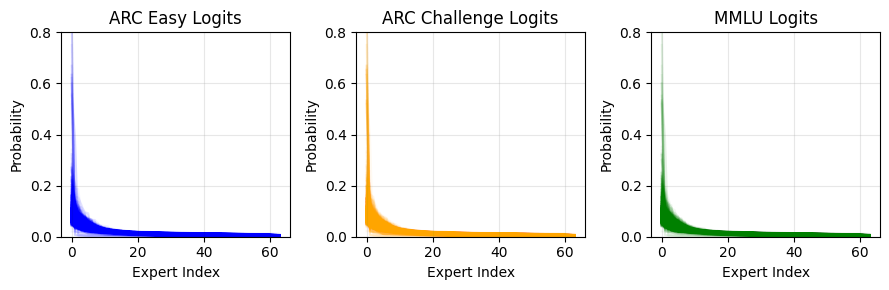

In [6]:
# Plot all logits for each dataset
plt.figure(figsize=(9, 3))

# ARC Easy
plt.subplot(1, 3, 1)
sample_easy = random.sample(arceasy_logits, min(len(arceasy_logits), 2000))
for l in sample_easy:
    plt.plot(l, color='blue', alpha=0.05)
plt.title(f'ARC Easy Logits')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

# ARC Challenge
plt.subplot(1, 3, 2)
sample_chal = random.sample(arcchallenge_logits, min(len(arcchallenge_logits), 2000))
for l in sample_chal:
    plt.plot(l, color='orange', alpha=0.05)
plt.title(f'ARC Challenge Logits')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

# MMLU
plt.subplot(1, 3, 3)
sample_mmlu = random.sample(mmlulogits, min(len(mmlulogits), 2000))
for l in sample_mmlu:
    plt.plot(l, color='green', alpha=0.05)
plt.title(f'MMLU Logits')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Total logits collected: 2616688
Scanning 50000 random logits to populate bins...


/tmp/ipython-input-2628122915.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = y_norm - x_norm


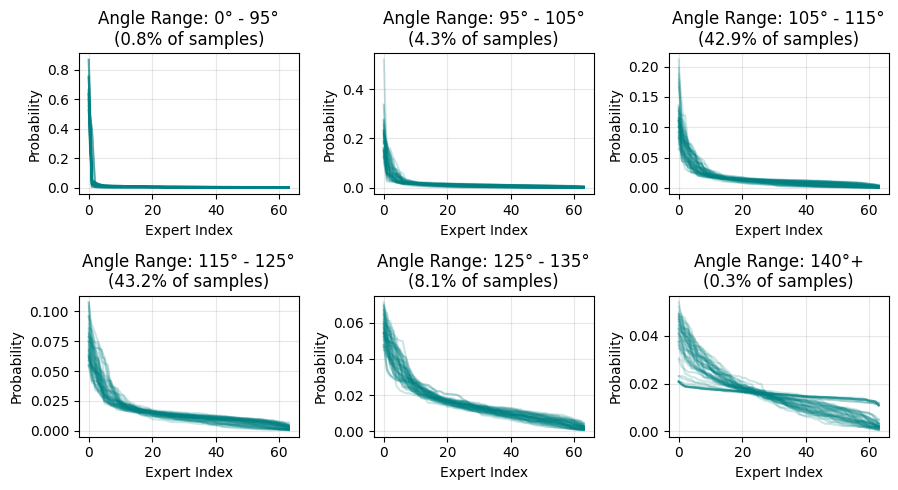

In [8]:
#Plot all logits by elbow angle

# --- 1. Collect All Logits ---
all_collected_logits = []
all_collected_logits.extend(arceasy_logits)
all_collected_logits.extend(arcchallenge_logits)
all_collected_logits.extend(mmlulogits)

print(f"Total logits collected: {len(all_collected_logits)}")

# --- 2. Group by Angle Ranges ---
ranges = [
    (0, 95, "0° - 95°"),
    (95, 105, "95° - 105°"),
    (105, 115, "105° - 115°"),
    (115, 125, "115° - 125°"),
    (125, 135, "125° - 135°"),
    (140, 181, "140°+")
]

binned_logits = {label: [] for _, _, label in ranges}

sample_size = min(50000, len(all_collected_logits))
sample_indices = np.random.choice(len(all_collected_logits), sample_size, replace=False)

print(f"Scanning {sample_size} random logits to populate bins...")
for i in sample_indices:
    y = all_collected_logits[i]
    y_tensor = torch.from_numpy(y).float()
    idx = calculate_geometric_elbow(y_tensor)
    ang = elbow_angle(y, idx)

    for low, high, label in ranges:
        if low <= ang < high:
            binned_logits[label].append(y)
            break

# --- 3. Plot ---
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
axes = axes.flatten()

for i, (low, high, label) in enumerate(ranges):
    ax = axes[i]
    logits_pool = binned_logits[label]
    count = len(logits_pool)
    percentage = (count / sample_size) * 100

    ax.set_title(f"Angle Range: {label}\n({percentage:.1f}% of samples)")
    ax.set_xlabel("Expert Index")
    ax.set_ylabel("Probability")

    if logits_pool:
        # Plot ~50 examples
        to_plot = random.sample(logits_pool, min(len(logits_pool), 50))
        for l in to_plot:
            ax.plot(l, color='teal', alpha=0.2)

        # Auto-scale y-axis based on actual data in this subplot
        all_vals = np.concatenate(to_plot)
        y_min = np.min(all_vals)
        y_max = np.max(all_vals)
        margin = (y_max - y_min) * 0.05  # 5% margin
        ax.set_ylim(y_min - margin, y_max + margin)
    else:
        ax.text(0.5, 0.5, "No samples found", ha='center', va='center', transform=ax.transAxes)
        ax.set_ylim(0, 1)  # Default range for empty plots

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Plotting sample logits with geometric elbows across angle ranges...


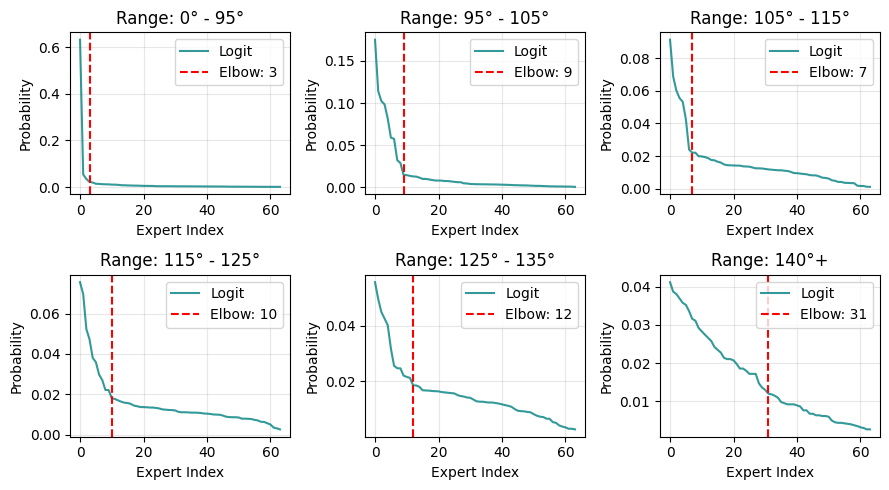

In [10]:
#Plot an example logit and elbow for each elbow range

# Keys corresponding to the ranges populated in the previous step
range_labels = [
    "0° - 95°",
    "95° - 105°",
    "105° - 115°",
    "115° - 125°",
    "125° - 135°",
    "140°+"
]

fig, axes = plt.subplots(2, 3, figsize=(9, 5))
axes = axes.flatten()

print("Plotting sample logits with geometric elbows across angle ranges...")

for i, label in enumerate(range_labels):
    ax = axes[i]

    # Check if bin exists and has data
    if 'binned_logits' in globals() and label in binned_logits and binned_logits[label]:
        # Pick one random logit
        logit = random.choice(binned_logits[label])

        # Calculate elbow
        elbow_idx = calculate_geometric_elbow(logit)

        # Plot
        ax.plot(logit, color='teal', alpha=0.8, linewidth=1.5, label="Logit")
        ax.axvline(elbow_idx, color='red', linestyle='--', label=f'Elbow: {elbow_idx}')

        ax.set_title(f"Range: {label}")
        ax.set_xlabel("Expert Index")
        ax.set_ylabel("Probability")
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No data in bin", ha='center', va='center')
        ax.set_title(f"Range: {label}")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Scanning 50000 random logits to populate bins...


/tmp/ipython-input-2628122915.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = y_norm - x_norm


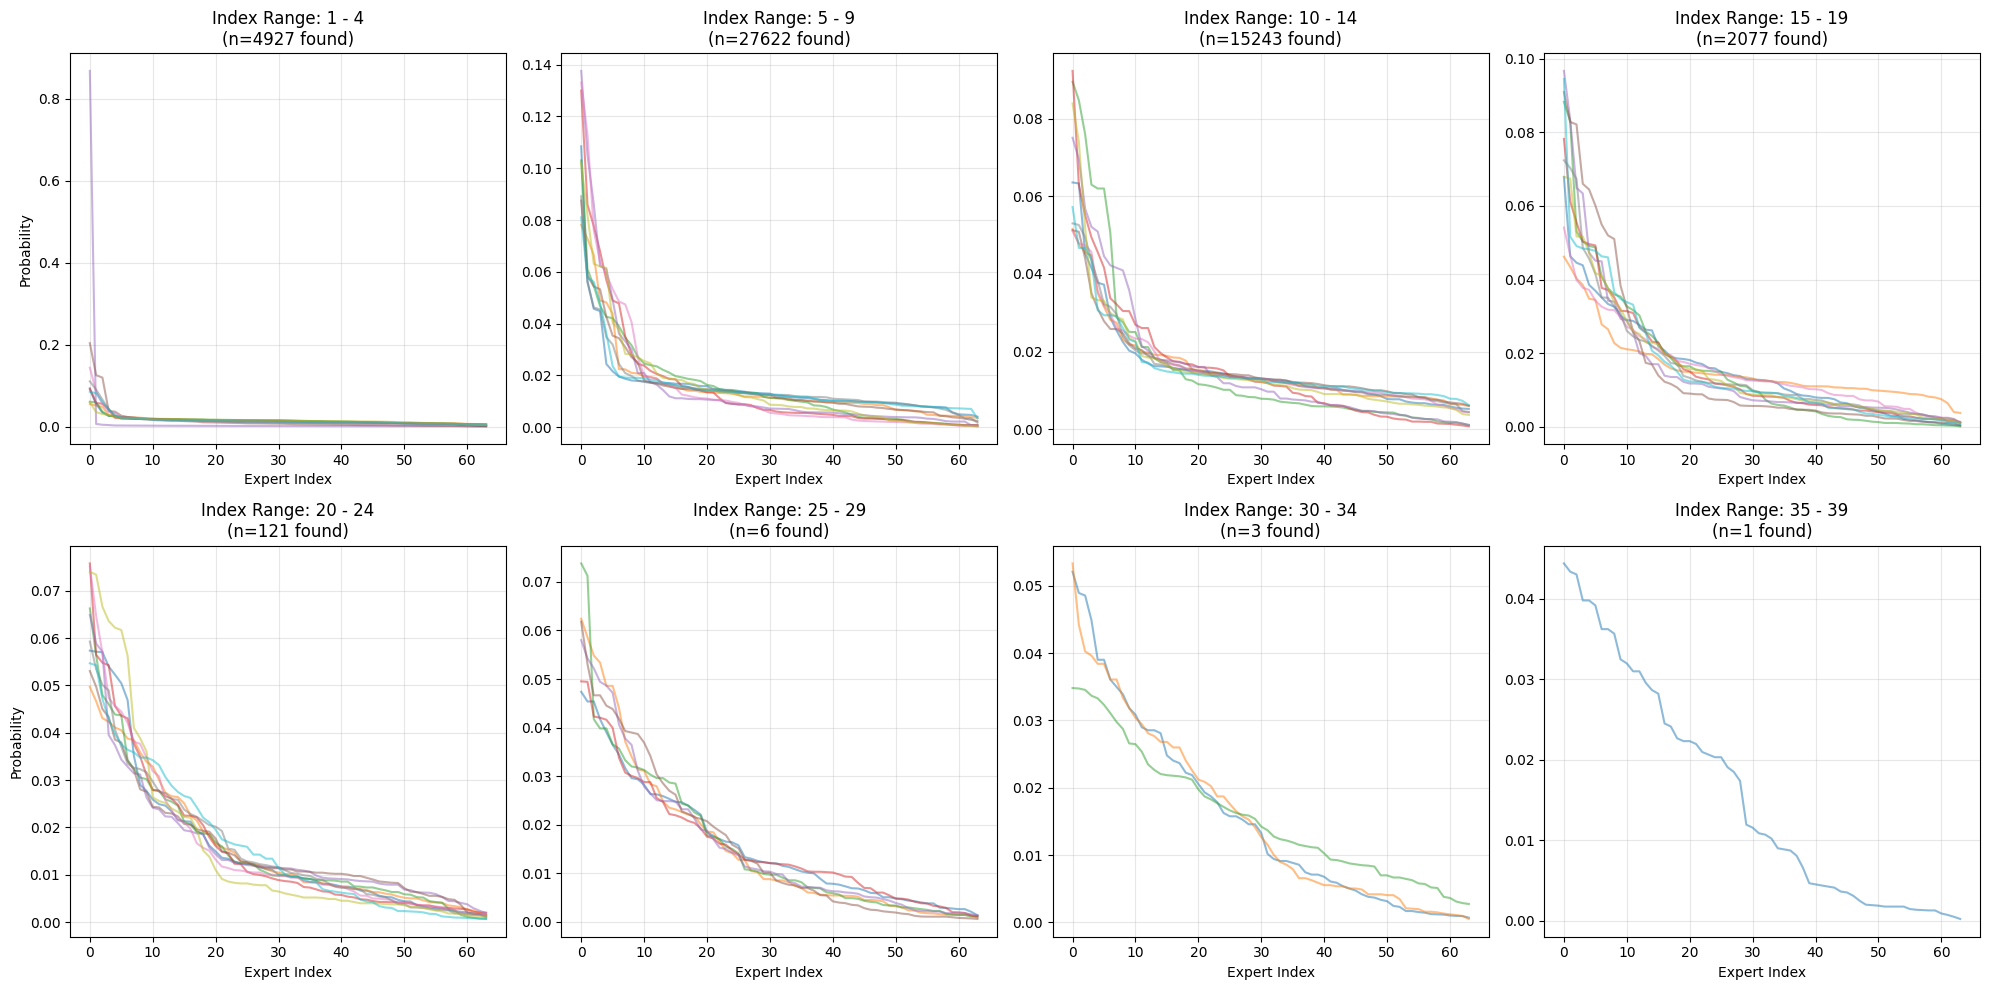

In [12]:
#Plot by elbow index

# Sample logits
sampled_logits_info = []
sample_size = min(50000, len(all_collected_logits))
sample_indices = np.random.choice(len(all_collected_logits), sample_size, replace=False)

print(f"Scanning {sample_size} random logits to populate bins...")
for i in sample_indices:
    y = all_collected_logits[i]
    y_tensor = torch.from_numpy(y).float()
    idx = calculate_geometric_elbow(y_tensor)
    ang = elbow_angle(y, idx)
    sampled_logits_info.append((idx, y))

# Determine range and create 8 bins for Indices
indices = [x[0] for x in sampled_logits_info]
min_idx, max_idx = min(indices), max(indices)

# Create bin edges (using linspace to divide the range into 8 intervals)
bin_edges = np.linspace(min_idx, max_idx + 1, 9)
bins = []
for i in range(8):
    bins.append((bin_edges[i], bin_edges[i+1]))

bin_data = {i: [] for i in range(8)}

# Populate bins
for idx, y_np in sampled_logits_info:
    for i, (low, high) in enumerate(bins):
        # Use < high for all except the last bin which includes the max
        if i == 7:
            if low <= idx <= high:
                bin_data[i].append(y_np)
                break
        else:
            if low <= idx < high:
                bin_data[i].append(y_np)
                break

# Create 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (low, high) in enumerate(bins):
    ax = axes[i]
    logits_list = bin_data[i]

    # Format title based on integer range
    if i == 7:
        title_range = f"{int(low)} - {int(high-1)}"
    else:
        title_range = f"{int(low)} - {int(high-1)}"

    ax.set_title(f"Index Range: {title_range}\n(n={len(logits_list)} found)")
    ax.set_xlabel("Expert Index")
    if i % 4 == 0:
        ax.set_ylabel("Probability")

    if logits_list:
        samples_to_plot = random.sample(logits_list, min(len(logits_list), 10))
        for logits in samples_to_plot:
            ax.plot(logits, alpha=0.5)
    else:
        ax.text(0.5, 0.5, "No samples found", ha='center', va='center')

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2628122915.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = y_norm - x_norm


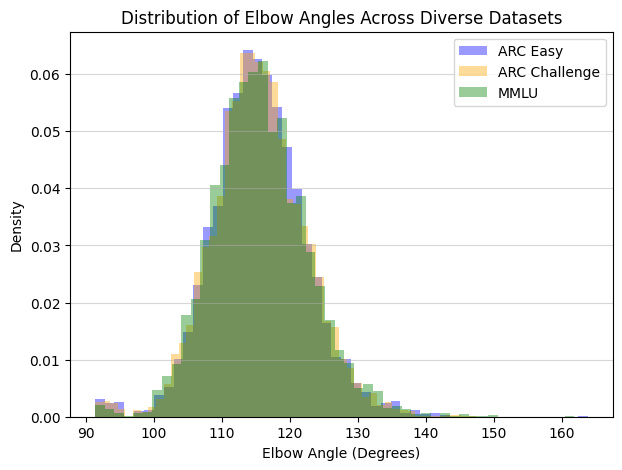

In [13]:
#Plot elbow angle distributions across datasets

def sample_logits(logits, n_samples=5000):
    """
    Safely samples n_samples from the provided logits tensor.
    If the tensor has fewer than n_samples, it returns the whole tensor.
    """
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(np.array(logits))

    total_samples = logits.size(0)

    if total_samples <= n_samples:
        return logits

    indices = torch.randperm(total_samples)[:n_samples]
    return logits[indices]


mmlu_sample = sample_logits(mmlulogits, 5000)
arc_easy_sample = sample_logits(arceasy_logits, 5000)
arc_challenge_sample = sample_logits(arcchallenge_logits, 5000)

mmlu_angles = []
for logit in mmlu_sample:
  idx = calculate_geometric_elbow(logit)
  ang = elbow_angle(logit, idx)
  mmlu_angles.append(ang)

arceasy_angles = []
for logit in arc_easy_sample:
  idx = calculate_geometric_elbow(logit)
  ang = elbow_angle(logit, idx)
  arceasy_angles.append(ang)

arcchallenge_angles = []
for logit in arc_challenge_sample:
  idx = calculate_geometric_elbow(logit)
  ang = elbow_angle(logit, idx)
  arcchallenge_angles.append(ang)

# 2. Plot Overlapped Histograms
plt.figure(figsize=(7, 5))

plt.hist(arceasy_angles, bins=50, alpha=0.4, label='ARC Easy', color='blue', density=True)

plt.hist(arcchallenge_angles, bins=50, alpha=0.4, label='ARC Challenge', color='orange', density=True)

plt.hist(mmlu_angles, bins=50, alpha=0.4, label='MMLU', color='green', density=True)

plt.title('Distribution of Elbow Angles Across Diverse Datasets')
plt.xlabel('Elbow Angle (Degrees)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
#process logits by layer
def get_elbow_results_by_layer(dataset_data):
    elbow_results_by_layer = defaultdict(lambda: {'idx_values': [], 'angle_values': []})
    for sample_idx, routers in dataset_data['router_logits'].items():
        for router_name, logits in routers.items():
            layer_idx_str = router_name.split('.')[2]
            layer_idx = int(layer_idx_str)
            processedlogits = []
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)
            processedlogits.extend(sorted_probs)
            for p in processedlogits:
              idx = calculate_geometric_elbow(p)
              ang = elbow_angle(p, idx) # Calculate elbow angle
              elbow_results_by_layer[layer_idx]['idx_values'].append(idx)
              elbow_results_by_layer[layer_idx]['angle_values'].append(ang)
    return elbow_results_by_layer

print("Processing MMLU data...")
mmlu_elbow_results = get_elbow_results_by_layer(mmlu)
print("Processing ARC Easy data...")
arceasy_elbow_results = get_elbow_results_by_layer(arceasy)
print("Processing ARC Challenge data...")
arcchallenge_elbow_results = get_elbow_results_by_layer(arcchallenge)

Sampling 400000 points from 1704304 total points for MMLU.
Sampling 400000 points from 456192 total points for ARC Easy.
Sampling 400000 points from 456192 total points for ARC Challenge.


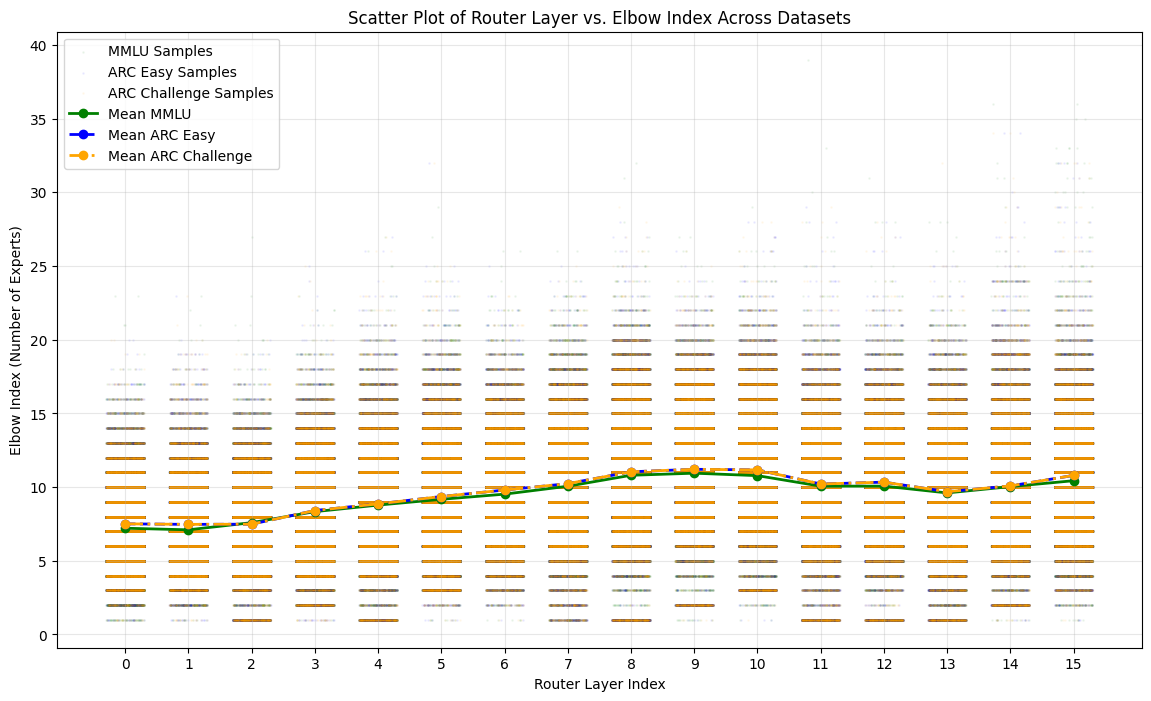

In [32]:
#Plot elbow indexes by layer

# --- Prepare data for plotting ---
plot_data = defaultdict(lambda: {'layers_x': [], 'elbow_idxs_y': []})
all_layer_indices = set() # To collect all layer indices across all datasets for xticks

MAX_PLOTTED_POINTS_PER_DATASET = 400000 # New constant for sampling per dataset

# Helper function to process, sample, and store data for a single dataset
def process_and_sample_dataset_for_plot(results_by_layer, dataset_label):
    global all_layer_indices # Declare global to modify the set

    dataset_points = []
    for layer_idx in sorted(results_by_layer.keys()):
        indices = results_by_layer[layer_idx]['idx_values']
        all_layer_indices.add(layer_idx)
        for elbow_idx in indices:
            dataset_points.append((layer_idx, elbow_idx)) # Collect points for this dataset

    # Sample for this specific dataset if there are too many points
    if len(dataset_points) > MAX_PLOTTED_POINTS_PER_DATASET:
        print(f"Sampling {MAX_PLOTTED_POINTS_PER_DATASET} points from {len(dataset_points)} total points for {dataset_label}.")
        sampled_dataset_points = random.sample(dataset_points, MAX_PLOTTED_POINTS_PER_DATASET)
    else:
        sampled_dataset_points = dataset_points
        print(f"Plotting all {len(dataset_points)} points for {dataset_label}.")

    # Distribute sampled points into plot_data with jitter
    for layer_idx, elbow_idx in sampled_dataset_points:
        jitter = np.random.uniform(-0.3, 0.3)
        plot_data[dataset_label]['layers_x'].append(layer_idx + jitter)
        plot_data[dataset_label]['elbow_idxs_y'].append(elbow_idx)

# Process each dataset individually for sampling
process_and_sample_dataset_for_plot(mmlu_elbow_results, 'MMLU')
process_and_sample_dataset_for_plot(arceasy_elbow_results, 'ARC Easy')
process_and_sample_dataset_for_plot(arcchallenge_elbow_results, 'ARC Challenge')

# Calculate mean elbow index per layer for each dataset
def calculate_mean_per_layer(results_by_layer):
    mean_indices_per_layer = []
    max_layer = max(results_by_layer.keys()) if results_by_layer else 0
    for layer_idx in range(max_layer + 1):
        if layer_idx in results_by_layer and results_by_layer[layer_idx]['idx_values']:
            mean_indices_per_layer.append(np.mean(results_by_layer[layer_idx]['idx_values']))
        else:
            mean_indices_per_layer.append(np.nan) # Use NaN for layers with no data
    return mean_indices_per_layer


mmlu_means = calculate_mean_per_layer(mmlu_elbow_results)
arceasy_means = calculate_mean_per_layer(arceasy_elbow_results)
arcchallenge_means = calculate_mean_per_layer(arcchallenge_elbow_results)

max_overall_layer = max(all_layer_indices) if all_layer_indices else 0


# --- Plotting ---
plt.figure(figsize=(14, 8))

# Define colors for each dataset
colors = {'MMLU': 'green', 'ARC Easy': 'blue', 'ARC Challenge': 'orange'}
linestyles = {'MMLU': '-', 'ARC Easy': '--', 'ARC Challenge': '-.'}


# Plot scatter points for each dataset
for dataset_label, data in plot_data.items():
    plt.scatter(data['layers_x'], data['elbow_idxs_y'], s=1, alpha=0.05,
                color=colors[dataset_label], label=f'{dataset_label} Samples')

# Plot mean lines for each dataset
if mmlu_means:
    plt.plot(range(len(mmlu_means)), mmlu_means, color=colors['MMLU'],
             marker='o', linestyle=linestyles['MMLU'], linewidth=2, label='Mean MMLU')
if arceasy_means:
    plt.plot(range(len(arceasy_means)), arceasy_means, color=colors['ARC Easy'],
             marker='o', linestyle=linestyles['ARC Easy'], linewidth=2, label='Mean ARC Easy')
if arcchallenge_means:
    plt.plot(range(len(arcchallenge_means)), arcchallenge_means, color=colors['ARC Challenge'],
             marker='o', linestyle=linestyles['ARC Challenge'], linewidth=2, label='Mean ARC Challenge')


plt.title('Scatter Plot of Router Layer vs. Elbow Index Across Datasets')
plt.xlabel('Router Layer Index')
plt.ylabel('Elbow Index (Number of Experts)')
plt.xticks(range(max_overall_layer + 1)) # Adjust x-ticks based on actual layers found
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [ ]:
# --- Plotting Separately for Each Dataset - Elbow Index ---
import matplotlib.pyplot as plt
import numpy as np

# Assuming plot_data, mmlu_means, arceasy_means, arcchallenge_means,
# all_layer_indices are already defined from the previous cell's execution.

max_overall_layer = max(all_layer_indices) if all_layer_indices else 0

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 1 row, 3 columns for separate plots

dataset_configs = {
    'MMLU': {'data': plot_data['MMLU'], 'means': mmlu_means, 'color': 'green', 'linestyle': '-'},
    'ARC Easy': {'data': plot_data['ARC Easy'], 'means': arceasy_means, 'color': 'blue', 'linestyle': '--'},
    'ARC Challenge': {'data': plot_data['ARC Challenge'], 'means': arcchallenge_means, 'color': 'orange', 'linestyle': '-.'},
}

for i, (dataset_label, config) in enumerate(dataset_configs.items()):
    ax = axes[i]

    # Plot scatter points
    if dataset_label in plot_data: # Ensure data exists for the dataset
        data = config['data']
        ax.scatter(data['layers_x'], data['elbow_idxs_y'], s=1, alpha=0.05,
                   color=config['color'], label=f'{dataset_label} Samples')

    # Plot mean lines
    means = config['means']
    if means:
        ax.plot(range(len(means)), means, color=config['color'],
                marker='o', linestyle=config['linestyle'], linewidth=2, label=f'Mean {dataset_label}')

    ax.set_title(f'Router Layer vs. Elbow Index: {dataset_label}')
    ax.set_xlabel('Router Layer Index')
    ax.set_ylabel('Elbow Index (Number of Experts)')

    ax.set_xticks(range(max_overall_layer + 1))
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

Sampling 400000 points from 1704304 total points for MMLU.
Sampling 400000 points from 456192 total points for ARC Easy.
Sampling 400000 points from 456192 total points for ARC Challenge.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


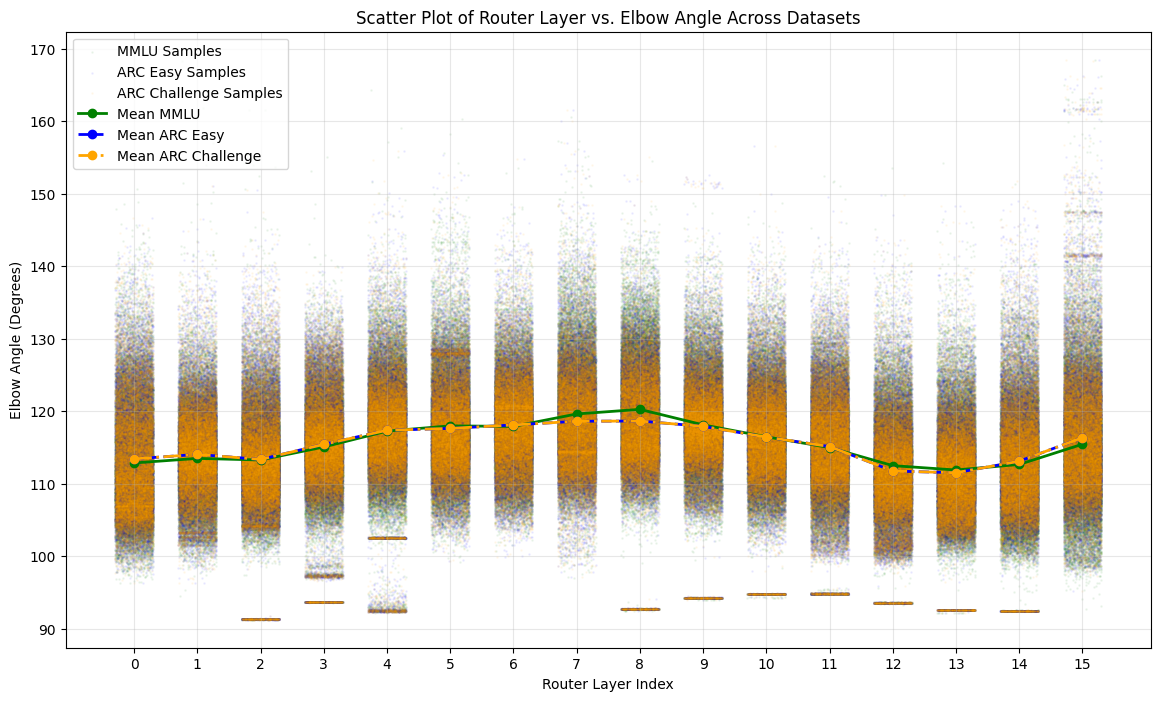

In [34]:
#plot elbow angles by layer

# --- Prepare data for plotting ---
plot_data = defaultdict(lambda: {'layers_x': [], 'elbow_angles_y': []})
all_layer_angles = set() # To collect all layer indices across all datasets for xticks

MAX_PLOTTED_POINTS_PER_DATASET = 400000 # New constant for sampling per dataset

# Helper function to process, sample, and store data for a single dataset
def process_and_sample_dataset_for_plot_elbow(results_by_layer, dataset_label):
    global all_layer_angles # Declare global to modify the set

    dataset_points = []
    for layer_idx in sorted(results_by_layer.keys()):
        angles = results_by_layer[layer_idx]['angle_values']
        all_layer_indices.add(layer_idx)
        for angle in angles:
            dataset_points.append((layer_idx, angle)) # Collect points for this dataset

    # Sample for this specific dataset if there are too many points
    if len(dataset_points) > MAX_PLOTTED_POINTS_PER_DATASET:
        print(f"Sampling {MAX_PLOTTED_POINTS_PER_DATASET} points from {len(dataset_points)} total points for {dataset_label}.")
        sampled_dataset_points = random.sample(dataset_points, MAX_PLOTTED_POINTS_PER_DATASET)
    else:
        sampled_dataset_points = dataset_points
        print(f"Plotting all {len(dataset_points)} points for {dataset_label}.")

    # Distribute sampled points into plot_data with jitter
    for layer_idx, angle in sampled_dataset_points:
        jitter = np.random.uniform(-0.3, 0.3)
        plot_data[dataset_label]['layers_x'].append(layer_idx + jitter)
        plot_data[dataset_label]['elbow_angles_y'].append(angle)

# Process each dataset individually for sampling
process_and_sample_dataset_for_plot_elbow(mmlu_elbow_results, 'MMLU')
process_and_sample_dataset_for_plot_elbow(arceasy_elbow_results, 'ARC Easy')
process_and_sample_dataset_for_plot_elbow(arcchallenge_elbow_results, 'ARC Challenge')

# Calculate mean elbow index per layer for each dataset
def calculate_mean_per_layer(results_by_layer):
    mean_indices_per_layer = []
    max_layer = max(results_by_layer.keys()) if results_by_layer else 0
    for layer_idx in range(max_layer + 1):
        if layer_idx in results_by_layer and results_by_layer[layer_idx]['angle_values']:
            mean_indices_per_layer.append(np.mean(results_by_layer[layer_idx]['angle_values']))
        else:
            mean_indices_per_layer.append(np.nan) # Use NaN for layers with no data
    return mean_indices_per_layer


mmlu_means = calculate_mean_per_layer(mmlu_elbow_results)
arceasy_means = calculate_mean_per_layer(arceasy_elbow_results)
arcchallenge_means = calculate_mean_per_layer(arcchallenge_elbow_results)

max_overall_layer = max(all_layer_indices) if all_layer_indices else 0


# --- Plotting ---
plt.figure(figsize=(14, 8))

# Define colors for each dataset
colors = {'MMLU': 'green', 'ARC Easy': 'blue', 'ARC Challenge': 'orange'}
linestyles = {'MMLU': '-', 'ARC Easy': '--', 'ARC Challenge': '-.'}


# Plot scatter points for each dataset
for dataset_label, data in plot_data.items():
    plt.scatter(data['layers_x'], data['elbow_angles_y'], s=1, alpha=0.05,
                color=colors[dataset_label], label=f'{dataset_label} Samples')

# Plot mean lines for each dataset
if mmlu_means:
    plt.plot(range(len(mmlu_means)), mmlu_means, color=colors['MMLU'],
             marker='o', linestyle=linestyles['MMLU'], linewidth=2, label='Mean MMLU')
if arceasy_means:
    plt.plot(range(len(arceasy_means)), arceasy_means, color=colors['ARC Easy'],
             marker='o', linestyle=linestyles['ARC Easy'], linewidth=2, label='Mean ARC Easy')
if arcchallenge_means:
    plt.plot(range(len(arcchallenge_means)), arcchallenge_means, color=colors['ARC Challenge'],
             marker='o', linestyle=linestyles['ARC Challenge'], linewidth=2, label='Mean ARC Challenge')


plt.title('Scatter Plot of Router Layer vs. Elbow Angle Across Datasets')
plt.xlabel('Router Layer Index')
plt.ylabel('Elbow Angle (Degrees)')
plt.xticks(range(max_overall_layer + 1)) # Adjust x-ticks based on actual layers found
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

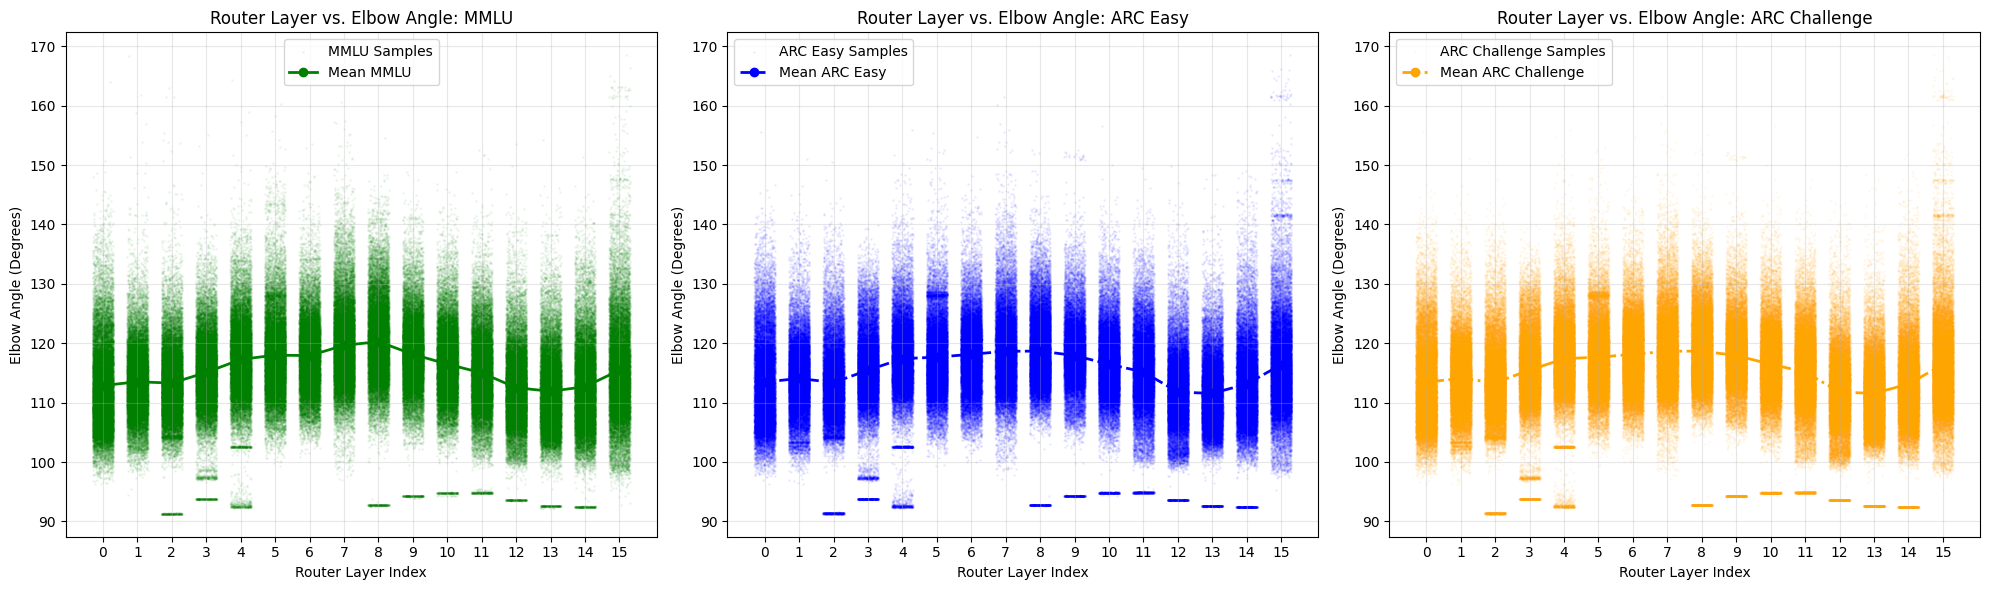

In [37]:
# --- Plotting Separately for Each Dataset - Elbow Angle ---
import matplotlib.pyplot as plt
import numpy as np

# Assuming plot_data, mmlu_means, arceasy_means, arcchallenge_means,
# all_layer_indices are already defined from the previous cell's execution.

max_overall_layer = max(all_layer_indices) if all_layer_indices else 0

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 1 row, 3 columns for separate plots

dataset_configs = {
    'MMLU': {'data': plot_data['MMLU'], 'means': mmlu_means, 'color': 'green', 'linestyle': '-'},
    'ARC Easy': {'data': plot_data['ARC Easy'], 'means': arceasy_means, 'color': 'blue', 'linestyle': '--'},
    'ARC Challenge': {'data': plot_data['ARC Challenge'], 'means': arcchallenge_means, 'color': 'orange', 'linestyle': '-.'},
}

for i, (dataset_label, config) in enumerate(dataset_configs.items()):
    ax = axes[i]

    # Plot scatter points
    if dataset_label in plot_data: # Ensure data exists for the dataset
        data = config['data']
        ax.scatter(data['layers_x'], data['elbow_angles_y'], s=1, alpha=0.05,
                   color=config['color'], label=f'{dataset_label} Samples')

    # Plot mean lines
    means = config['means']
    if means:
        ax.plot(range(len(means)), means, color=config['color'],
                marker='o', linestyle=config['linestyle'], linewidth=2, label=f'Mean {dataset_label}')

    ax.set_title(f'Router Layer vs. Elbow Angle: {dataset_label}')
    ax.set_xlabel('Router Layer Index')
    ax.set_ylabel('Elbow Angle (Degrees)')

    ax.set_xticks(range(max_overall_layer + 1))
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

Searching for samples with Elbow Angle > 155 degrees...

==================== Example 1 (ARC Easy) ====================
Layer: model.layers.15.mlp.gate | Elbow Angle: 163.88° | Elbow Idx: 24
Question:
For the reaction between silver nitrate and sodium chloride, which of the following would be a product? AgNo_{3} + NaCl ->
(A) AgNa
(B) ClNO_{3}
(C) Na_{3}NO
(D) AgCl

==================== Example 2 (ARC Easy) ====================
Layer: model.layers.7.mlp.gate | Elbow Angle: 155.85° | Elbow Idx: 12
Question:
If Earth revolved at a faster rate, what would most likely occur?
(A) Annual rainfall would increase.
(B) Daylight hours would decrease.
(C) Seasons would be shorter.
(D) Annual temperature variation would be greater.

==================== Example 3 (ARC Easy) ====================
Layer: model.layers.15.mlp.gate | Elbow Angle: 161.00° | Elbow Idx: 9
Question:
To study the effect of heat on plant growth, Andy divided ten identical seedlings into groups. She placed one group on a windo

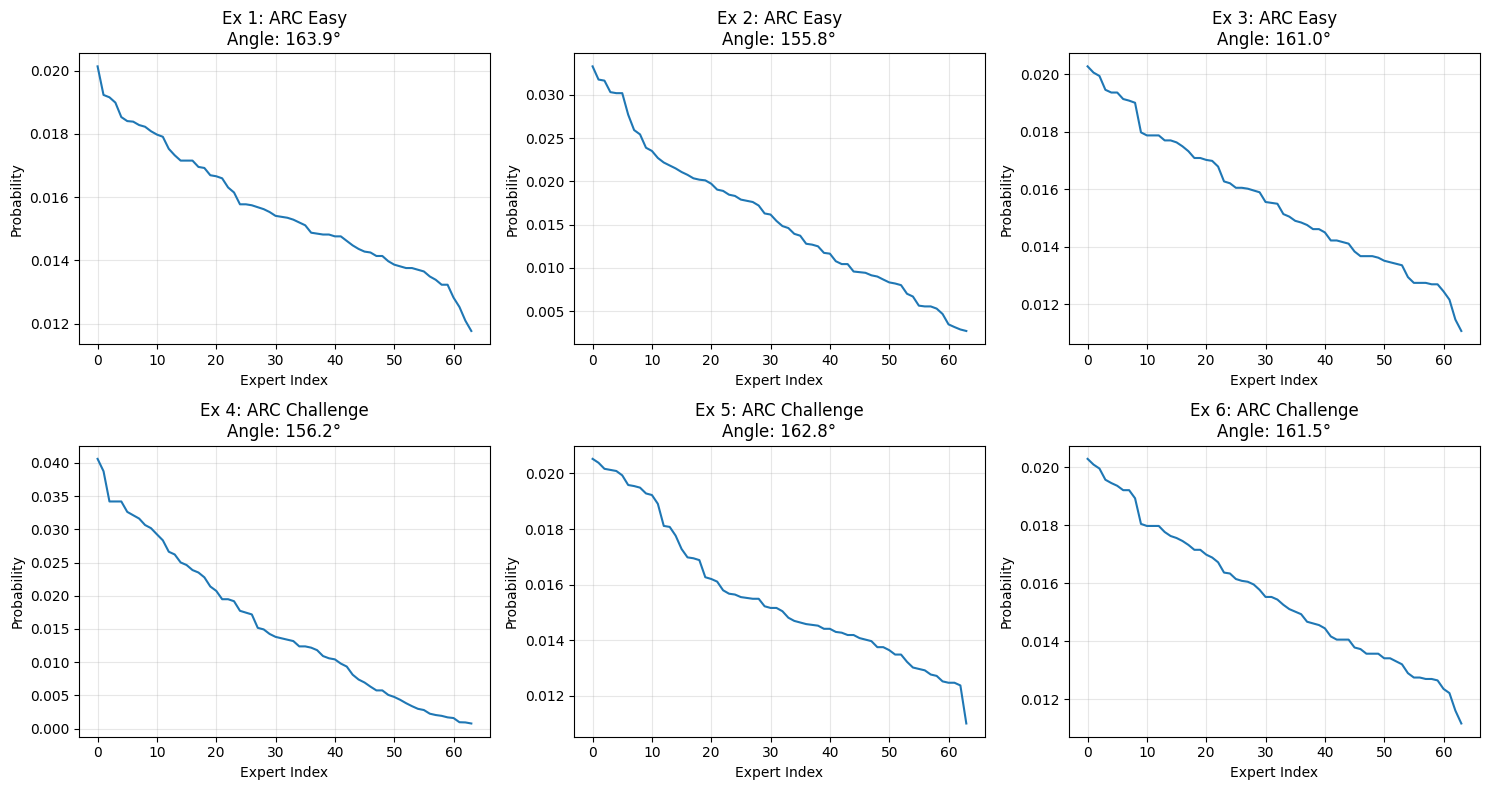

In [ ]:
#plot and look at questions for a few high angle samples
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure helper functions are available
# (relying on calculate_original_elbow_np and elbow_angle_np from previous cells)

def find_high_angle_samples(dataset_data, dataset_name, threshold=155, num_examples=3):
    found_samples = []
    count = 0

    # Iterate samples
    for sample_idx, sample_data in enumerate(dataset_data['samples']):
        if count >= num_examples: break

        logits_dict = dataset_data['router_logits'][sample_idx]

        # iterate layers/logits
        for router_name, logits in logits_dict.items():
            if count >= num_examples: break

            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)

            # Process logits (Softmax + Sort)
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)
            sorted_probs_np = sorted_probs.cpu().numpy()

            # Check each token's logit
            # We'll just check the first few tokens to avoid excessive loop time,
            # or check all if efficient enough. Checking all for robustness.
            for row_idx, row in enumerate(sorted_probs_np):
                idx = calculate_original_elbow_np(row)
                angle = elbow_angle_np(row, idx)

                if angle > threshold:
                    # Found one!
                    q_text = dataset_data['samples'][sample_idx]['question']
                    choices = dataset_data['samples'][sample_idx]['choices']

                    # Format choices nicely
                    formatted_choices = "\n".join([f"({l}) {t}" for l, t in zip(choices['label'], choices['text'])])
                    formatted_q = f"{q_text}\n{formatted_choices}"

                    found_samples.append({
                        'question': formatted_q,
                        'logit': row,
                        'angle': angle,
                        'layer': router_name,
                        'dataset': dataset_name,
                        'elbow_idx': idx
                    })
                    count += 1
                    break # Move to next sample to avoid duplicate questions
    return found_samples

# Find samples
print("Searching for samples with Elbow Angle > 155 degrees...")
high_angle_samples = []
high_angle_samples.extend(find_high_angle_samples(arceasy, "ARC Easy", threshold=155))
high_angle_samples.extend(find_high_angle_samples(arcchallenge, "ARC Challenge", threshold=155))

# Print Questions
for i, sample in enumerate(high_angle_samples):
    print(f"\n{'='*20} Example {i+1} ({sample['dataset']}) {'='*20}")
    print(f"Layer: {sample['layer']} | Elbow Angle: {sample['angle']:.2f}° | Elbow Idx: {sample['elbow_idx']}")
    print(f"Question:\n{sample['question']}")

# Plot Logits
if high_angle_samples:
    rows = (len(high_angle_samples) + 2) // 3
    plt.figure(figsize=(15, 4 * rows))
    for i, sample in enumerate(high_angle_samples):
        plt.subplot(rows, 3, i+1)
        plt.plot(sample['logit'])
        plt.title(f"Ex {i+1}: {sample['dataset']}\nAngle: {sample['angle']:.1f}°")
        plt.xlabel("Expert Index")
        plt.ylabel("Probability")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No samples found with that threshold.")

In [38]:
# Process and plot elbow angles and indexes across subjects

def get_elbow_results_by_subject(dataset_data):
    elbow_results_by_subject = defaultdict(lambda: {'idx_values': [], 'angle_values': []})
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Iterate through samples from the dataset_data
    for sample_idx, routers in dataset_data['router_logits'].items():
        # Retrieve the subject for the current sample
        # Assuming 'subject' key exists in the sample data
        if 'subject' in dataset_data['samples'][sample_idx]:
            subject = dataset_data['samples'][sample_idx]['subject']
        else:
            # Fallback if 'subject' is not directly in sample, maybe use dataset_key
            # This case might need adjustment based on how the 'subject' is truly available
            subject = dataset_data['dataset_key'] + "_general"

        # Iterate through router logits for the current sample
        for router_name, logits in routers.items():
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits, device=device)
            else:
                logits = logits.to(device)

            # Ensure logits are float32 for softmax stability
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)

            # Iterate through each row (token's probabilities) in sorted_probs
            for p in sorted_probs:
                # Convert to numpy for elbow calculations (as helper funcs expect numpy or compatible)
                p_np = p.cpu().numpy()
                idx = calculate_geometric_elbow(p_np)
                ang = elbow_angle(p_np, idx)

                elbow_results_by_subject[subject]['idx_values'].append(idx)
                elbow_results_by_subject[subject]['angle_values'].append(ang)
    return elbow_results_by_subject

print("Processing MMLU data by subject...")
mmlu_elbow_results_by_subject = get_elbow_results_by_subject(mmlu)
print(f"Processed {len(mmlu_elbow_results_by_subject)} subjects from MMLU.")

# Optionally, print some stats to verify
for subject, data in mmlu_elbow_results_by_subject.items():
    print(f"Subject: {subject}, Samples: {len(data['idx_values'])}")


Processing MMLU data by subject...
Processed 57 subjects from MMLU.
Subject: professional_law, Samples: 426240
Subject: business_ethics, Samples: 6208
Subject: miscellaneous, Samples: 53440
Subject: moral_scenarios, Samples: 115424
Subject: astronomy, Samples: 6736
Subject: machine_learning, Samples: 7152
Subject: world_religions, Samples: 8560
Subject: conceptual_physics, Samples: 13536
Subject: professional_accounting, Samples: 36880
Subject: high_school_government_and_politics, Samples: 16656
Subject: moral_disputes, Samples: 36608
Subject: high_school_us_history, Samples: 80720
Subject: logical_fallacies, Samples: 14480
Subject: high_school_statistics, Samples: 31728
Subject: high_school_macroeconomics, Samples: 24096
Subject: elementary_mathematics, Samples: 24720
Subject: marketing, Samples: 12192
Subject: human_aging, Samples: 11104
Subject: nutrition, Samples: 16064
Subject: philosophy, Samples: 18032
Subject: high_school_chemistry, Samples: 15440
Subject: clinical_knowledge, S

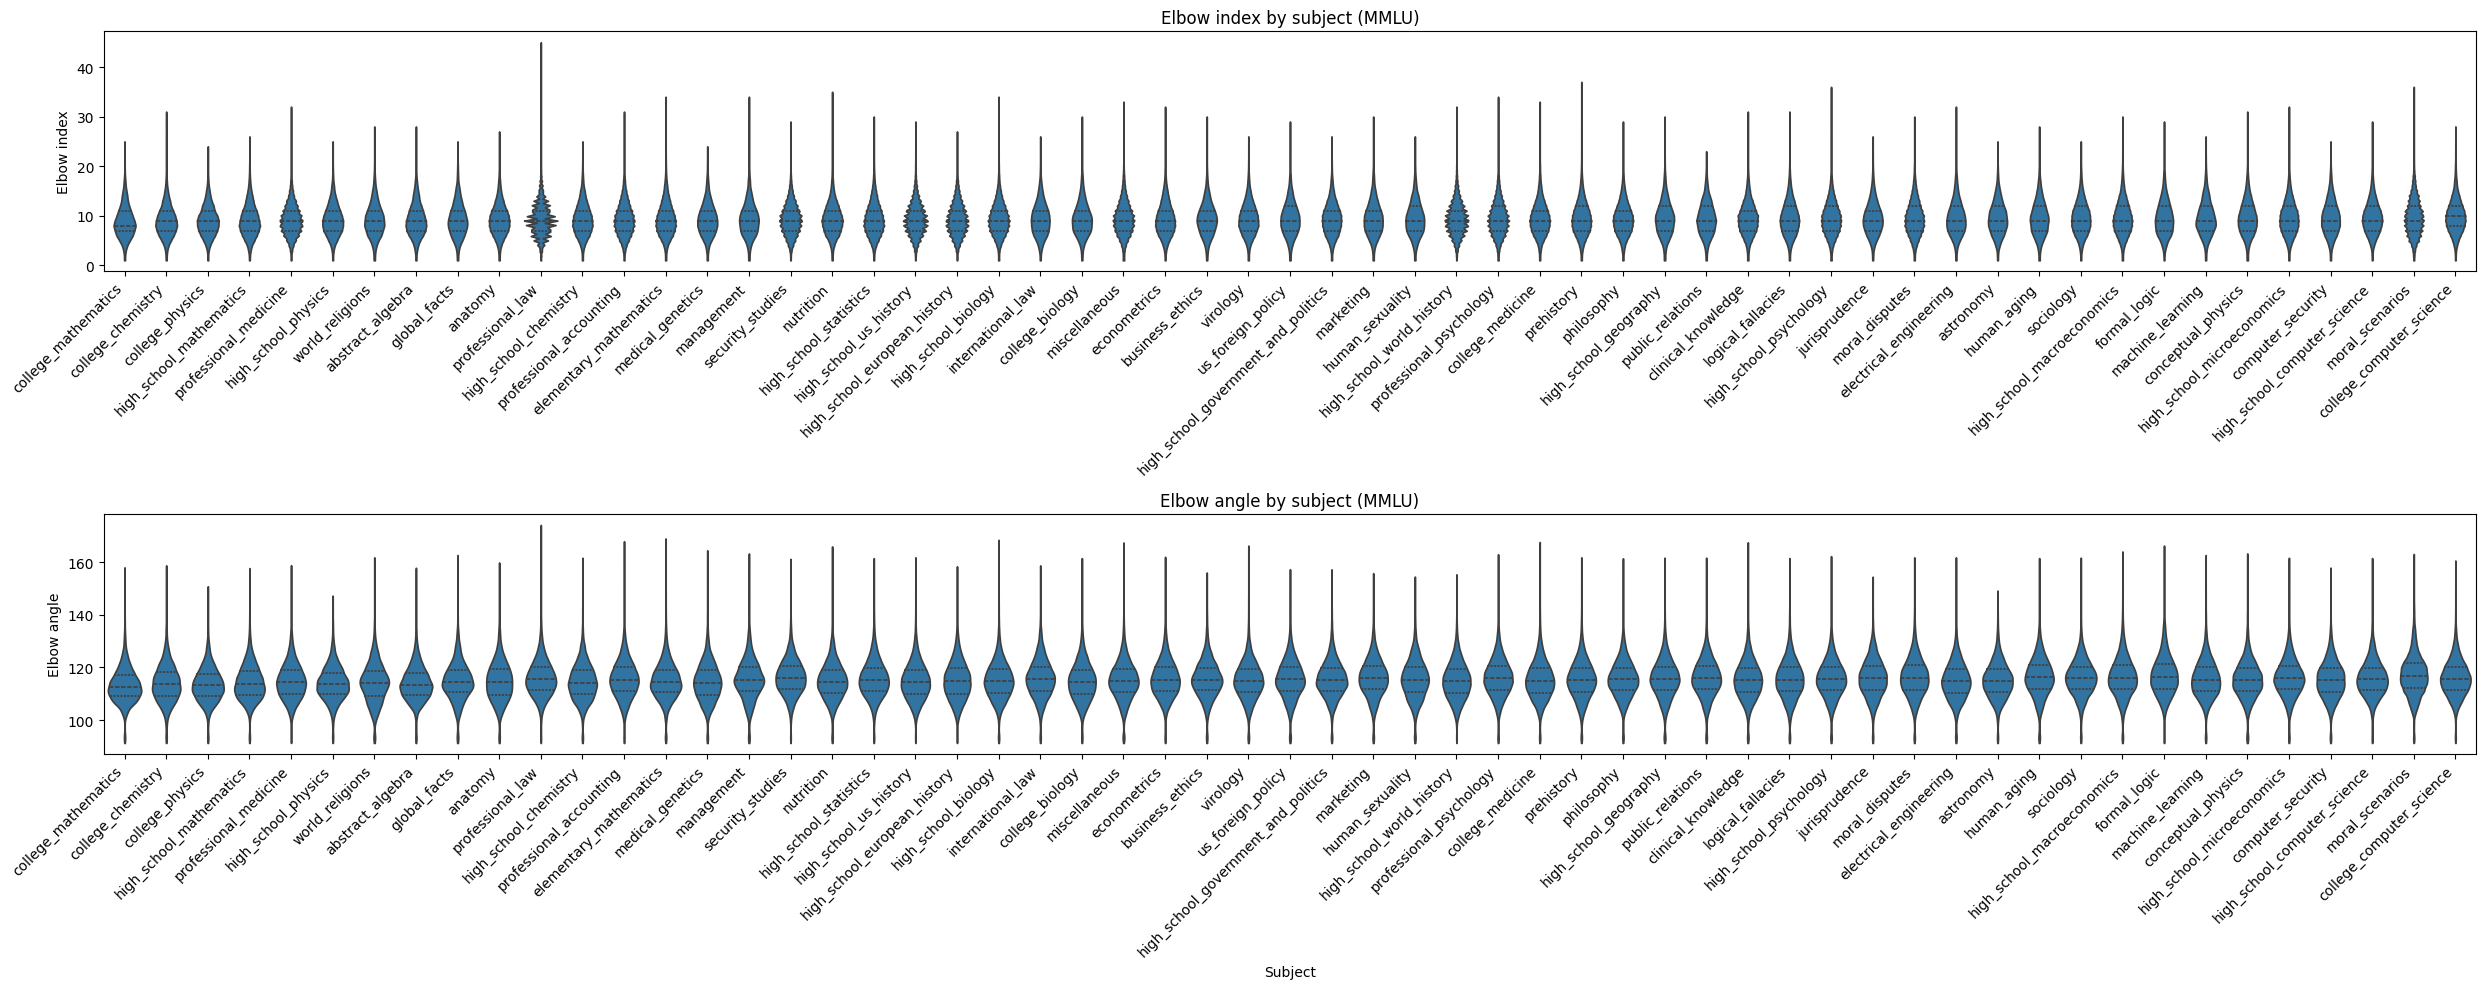

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def elbow_results_to_df(elbow_results_by_subject):
    """
    Convert the elbow_results_by_subject dict into a long-form DataFrame
    with columns: subject, elbow_idx, elbow_angle.
    """
    rows = []
    for subject, data in elbow_results_by_subject.items():
        idx_values = data["idx_values"]
        angle_values = data["angle_values"]
        for idx, ang in zip(idx_values, angle_values):
            rows.append({
                "subject": subject,
                "elbow_idx": idx,
                "elbow_angle": ang,
            })
    return pd.DataFrame(rows)

def plot_elbow_violins(elbow_results_by_subject, dataset_name="MMLU"):
    df = elbow_results_to_df(elbow_results_by_subject)

    # Optional: sort subjects by mean elbow_idx (or alphabetically)
    subject_order = (
        df.groupby("subject")["elbow_idx"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )

    plt.figure(figsize=(25, 10))

    # --- Top: elbow index ---
    plt.subplot(2, 1, 1)
    sns.violinplot(
        data=df,
        x="subject",
        y="elbow_idx",
        order=subject_order,
        inner="quartile",
        cut=0,
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Elbow index by subject ({dataset_name})")
    plt.xlabel("")  # no x-label here so it doesn't duplicate
    plt.ylabel("Elbow index")

    # --- Bottom: elbow angle ---
    plt.subplot(2, 1, 2)
    sns.violinplot(
        data=df,
        x="subject",
        y="elbow_angle",
        order=subject_order,
        inner="quartile",
        cut=0,
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Elbow angle by subject ({dataset_name})")
    plt.xlabel("Subject")
    plt.ylabel("Elbow angle")

    plt.tight_layout()
    plt.show()

# Usage:
plot_elbow_violins(mmlu_elbow_results_by_subject, dataset_name="MMLU")

